In [131]:
import glob
import os
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import k_means
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random

from matplotlib import pyplot as plt

In [28]:
# ingest corpus, label by dir
texts = {}
for f in glob.glob('./bbc/*/*'):
    if not 'txt' in f:
        continue
    lbl = f.split('/')[2]
    if not lbl in texts:
        texts[lbl] = []
    with open(f) as fh:
        try:
            contents = ' '.join(fh.readlines())
            texts[lbl].append(contents)
        except Exception:
            print('error processing', f)

error processing ./bbc/sport/199.txt


In [30]:
len(texts['business'])
all_texts = []
for k in texts:
    all_texts.extend(texts[k])

In [38]:
tfiv = TfidfVectorizer()
mat = tfiv.fit_transform(all_texts)

In [39]:
mat.shape

(2224, 29418)

In [97]:
svd = TruncatedSVD(n_components=50)

In [98]:
svd.fit(mat)

TruncatedSVD(n_components=50)

In [99]:
mat50 = svd.transform(mat)
mat50.shape

(2224, 50)

In [139]:
_, labels, _ = k_means(mat50, n_clusters=5)

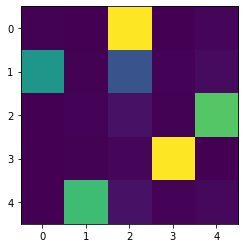

In [138]:
# crappy heatmap.
# looks like we can recover *some* classes well, but others not so much.
# cluster 2 in particular does not discriminate well.
true_labels = []
for i, k in enumerate(texts.keys()):
    true_labels.extend([i]*len(texts[k]))
a = [random.random()/4 + g for g in true_labels]
b = [random.random()/4 + g for g in labels]

plt.imshow(confusion_matrix(true_labels, labels))

In [110]:
label_mapping = {k: i for i, k in enumerate(texts.keys())}
labels_numeric = []
for k in texts:
    labels_numeric.extend([label_mapping[k]]*len(texts[k]))


In [113]:
clf = GaussianNB()
clf.fit(mat50, labels_numeric)

GaussianNB()

In [116]:
yhat_train = clf.predict(mat50)
y = labels_numeric

In [118]:
accuracy_score(y,yhat_train)

0.9127697841726619

In [127]:
# test set accuracy
X_train, X_test, y_train, y_test = train_test_split(mat50, y)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test) 
accuracy_score(y_test,yhat)

0.9100719424460432

In [132]:
confusion_matrix(y_test, yhat)

array([[111,   5,   2,   2,  11],
       [  0, 100,   1,   1,   2],
       [  1,   6,  81,   0,   7],
       [  0,   0,   0, 120,   2],
       [  0,   4,   3,   3,  94]])

In [133]:
# now let's say we have a new doc and want to know about it
# "find nearest" can be done with cosine distance to doc matrix
# classification can be done with classifier